1) 데이터 준비와 확인

In [1]:
#!ln -s ~/data/*.txt ~/aiffel/sentiment_classification/data

In [2]:
import pandas as pd
import urllib.request
%matplotlib inline
import matplotlib.pyplot as plt
import re
from konlpy.tag import Okt
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from collections import Counter

# 데이터를 읽어봅시다. 
train_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_train.txt')
test_data = pd.read_table('~/aiffel/sentiment_classification/data/ratings_test.txt')

id: 유저아이디, document: 리뷰 텍스트, label: 긍정/부정 여부 (긍정=1, 부정=0)

In [3]:
display(train_data)    # 15만개
display(test_data)     # 5만개

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1
...,...,...,...
149995,6222902,인간이 문제지.. 소는 뭔죄인가..,0
149996,8549745,평점이 너무 낮아서...,1
149997,9311800,이게 뭐요? 한국인은 거들먹거리고 필리핀 혼혈은 착하다?,0
149998,2376369,청춘 영화의 최고봉.방황과 우울했던 날들의 자화상,1


,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
...,...,...,...
49995,4608761,오랜만에 평점 로긴했네ㅋㅋ 킹왕짱 쌈뽕한 영화를 만났습니다 강렬하게 육쾌함,1
49996,5308387,의지 박약들이나 하는거다 탈영은 일단 주인공 김대희 닮았고 이등병 찐따 OOOO,0
49997,9072549,그림도 좋고 완성도도 높았지만... 보는 내내 불안하게 만든다,0
49998,5802125,절대 봐서는 안 될 영화.. 재미도 없고 기분만 잡치고.. 한 세트장에서 다 해먹네,0


긍정/부정 레이블 분포

<AxesSubplot:>

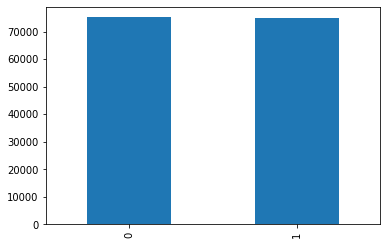

In [4]:
train_data['label'].value_counts().plot(kind = 'bar')

2) 데이터로더 구성

imdb.data_loader()와 동일하게 동작하는 data_loader를 만든다. 다음과 같은 동작을 수행한다.

데이터의 중복 제거, NaN 결측치 제거, 한국어 토크나이저로 토큰화, 불용어(Stopwords) 제거, 사전word_to_index 구성, 텍스트 스트링을 사전 인덱스 스트링으로 변환, X_train, y_train, X_test, y_test, word_to_index 리턴

속도가 압도적으로 제일빠른 Mecab이 적합하다.

In [5]:
import re
from konlpy.tag import Mecab
tokenizer = Mecab()
stopwords = ['의','가','이','은','들','는','과','도','를','으로','자','에','와','한','하다', '이다']

def load_data(train_data, test_data, num_words=10000):
    # 1) 특수기호 및 공백 제거
    train_data['document'] = train_data['document'].str.replace(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
    #re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]', '', train_data['document'])
    
    train_data['document'] = train_data['document'].str.replace('^ +', "")
    train_data['document'].replace('', np.nan, inplace=True)
    
    # 2) 중복 및 결측치 제거
    train_data.drop_duplicates(subset=['document'], inplace=True)    # subset에 중복데이터를 처리할 칼럼명을 전달
    train_data = train_data.dropna(how = 'any')    # NaN이 있으면 제거
    test_data.drop_duplicates(subset=['document'], inplace=True)
    test_data = test_data.dropna(how = 'any') 
    
    # 3) 토큰화 및 불용어 제거
    X_train = []
    for sentence in train_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_train.append(temp_X)

    X_test = []
    for sentence in test_data['document']:
        temp_X = tokenizer.morphs(sentence) # 토큰화
        temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
        X_test.append(temp_X)
    
    # 4) 단어사전 구성
    words = np.concatenate(X_train).tolist() # 단어들을 리스트로 저장
    counter = Counter(words)
    counter = counter.most_common(num_words-4)   # count기준 상위 num_words-4개의 단어로 축소
    #print(counter)
    vocab = ['', '', '', ''] + [key for key, _ in counter]    # 리스트 5번째부터 토큰화한 단어가 count 큰 순으로 저장됨
    #print(vocab)
    word_to_index = {word:index for index, word in enumerate(vocab)}    # 키: 단어, 값: 인덱스(3~num_words-1)
    #print(word_to_index)
    
    # 5) 텍스트 문자열을 사전인덱스 문자열로 변환
    def wordlist_to_indexlist(wordlist):
        # 키==단어이면 단어의 인덱스, 해당하는 단어가 없으면 3
        return [word_to_index[word] if word in word_to_index else word_to_index[''] for word in wordlist]
    
    # X_train 또는 X_test의 모든 원소에 wordlist_to_indexlist함수를 적용시킨 결과들을 리스트로 저장
    # X_train과 X_test는 각 문장에 있는 모든 단어가 담긴 이중리스트였으므로
    # 원래 단어가 있던 곳에 해당하는 인덱스가 들어간 이중리스트가 된다.
    X_train = list(map(wordlist_to_indexlist, X_train))
    X_test = list(map(wordlist_to_indexlist, X_test))
        
    return X_train, np.array(list(train_data['label'])), X_test, np.array(list(test_data['label'])), word_to_index

vocab_size = 30000
X_train, y_train, X_test, y_test, word_to_index = load_data(train_data, test_data, num_words=vocab_size) 

/tmp/ipykernel_1355/881825640.py:8: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace(r"[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","")
/tmp/ipykernel_1355/881825640.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  train_data['document'] = train_data['document'].str.replace('^ +', "")


train 데이터

In [6]:
print(X_train[:10])
print(y_train[:10])

[[27, 68, 894, 33, 216, 15, 28, 701], [997, 483, 494, 639, 4, 112, 1556, 47, 867, 950, 11, 38, 366], [19, 194, 28635], [8034, 145, 4134, 280, 88, 13, 5, 52, 3329], [21628, 8491, 1052, 47, 2701, 55, 4, 2623, 34, 1119, 29, 325, 36, 17, 35, 55, 15312, 21629, 395, 2878, 1677, 5], [628, 21630, 17796, 427, 173, 1465, 663, 1593, 672, 46, 28636, 4, 62, 2169, 120, 723], [239, 352, 8, 356, 1921, 51, 11, 782, 5], [235, 1360, 135, 5, 393, 710, 10358, 15313, 47, 1435, 271, 94, 234, 23, 889, 24, 323, 611, 503, 478, 549, 5, 3168, 8492, 17, 1385, 1385, 67, 284, 13, 5, 47, 97, 7, 70, 17, 28637, 37], [118, 13, 18, 88, 12, 271, 22, 43, 4], [58, 615, 52, 227, 708, 535, 83, 17, 480, 1405, 599, 691, 75, 17, 19, 15314, 12, 15]]
[0 1 0 0 1 0 0 0 1 1]


In [7]:
len(X_train)

143620

test 데이터

In [8]:
print(X_test[:10])
print(y_test[:10])

[[805, 130], [3], [81, 111, 52, 3, 3, 898, 316, 38, 30, 3, 40, 600, 3401, 65, 865], [90, 7, 11, 38, 218, 127, 330, 123, 3, 3, 140, 50, 6, 9, 36, 3, 3], [3, 3, 17, 65, 16, 432, 235, 2013, 120, 522, 8, 548, 3, 3, 58, 3, 3, 24, 595, 329, 19691, 794, 7, 10, 7, 278, 3, 3], [223, 50, 148, 3, 53, 223, 4], [580, 99], [1046, 423, 573, 34, 13046, 64, 4707, 1592, 13, 1469, 4089, 173, 3, 5619, 2804, 10, 188], [524, 1231, 43, 637, 4, 221, 7, 6, 82, 13, 26, 2849, 461, 5, 116, 114, 48, 22, 43, 2821, 221, 3, 3, 27, 1334, 5, 16571, 32, 4, 119, 3, 467, 1509, 301, 5], [2801, 1371, 585, 10809, 779, 3017, 3842, 3, 3, 256, 70, 310, 11, 38, 37, 3, 3]]
[1 0 0 0 0 1 0 0 0 1]


In [9]:
len(X_test)

49157

3) 모델 구성을 위한 데이터 분석 및 가공

데이터셋 내 문장 길이 분포, 적절한 최대 문장 길이 지정,keras.preprocessing.sequence.pad_sequences 을 활용한 패딩 추가

키: 인덱스, 값: 단어로 가지는 딕셔너리

In [10]:
index_to_word = {index:word for word, index in word_to_index.items()}
index_to_word

{3: '',
 4: '영화',
 5: '다',
 6: '고',
 7: '하',
 8: '을',
 9: '보',
 10: '게',
 11: '지',
 12: '있',
 13: '없',
 14: '좋',
 15: '나',
 16: '었',
 17: '만',
 18: '는데',
 19: '너무',
 20: '봤',
 21: '적',
 22: '안',
 23: '정말',
 24: '로',
 25: '것',
 26: '음',
 27: '아',
 28: '네요',
 29: '어',
 30: '지만',
 31: '재밌',
 32: '같',
 33: '진짜',
 34: '에서',
 35: '했',
 36: '기',
 37: '네',
 38: '않',
 39: '거',
 40: '점',
 41: '았',
 42: '수',
 43: '되',
 44: '면',
 45: 'ㅋㅋ',
 46: '인',
 47: '연기',
 48: '말',
 49: '잘',
 50: '주',
 51: '내',
 52: '평점',
 53: '최고',
 54: '이런',
 55: '던',
 56: '어요',
 57: '할',
 58: '왜',
 59: '겠',
 60: '스토리',
 61: '해',
 62: 'ㅋㅋㅋ',
 63: '습니다',
 64: '듯',
 65: '아니',
 66: '생각',
 67: '드라마',
 68: '더',
 69: '그',
 70: '사람',
 71: '싶',
 72: '때',
 73: '감동',
 74: '배우',
 75: '함',
 76: '본',
 77: '까지',
 78: '좀',
 79: '알',
 80: '만들',
 81: '뭐',
 82: '내용',
 83: '볼',
 84: '보다',
 85: '감독',
 86: '라',
 87: '그냥',
 88: '재미',
 89: '시간',
 90: '지루',
 91: '중',
 92: '재미있',
 93: '였',
 94: '년',
 95: '잼',
 96: '사랑',
 97: '못',
 98: '냐',
 99: '쓰레

In [11]:
# 문장 1개를 활용할 딕셔너리와 함께 주면, 단어 인덱스 리스트 벡터로 변환해 주는 함수입니다. 
# 단, 모든 문장은 <BOS>로 시작하는 것으로 합니다. 
def get_encoded_sentence(sentence, word_to_index):
    return [word_to_index['<BOS>']]+[word_to_index[word] if word in word_to_index else word_to_index['<UNK>'] for word in sentence.split()]

# 여러 개의 문장 리스트를 한꺼번에 단어 인덱스 리스트 벡터로 encode해 주는 함수입니다. 
def get_encoded_sentences(sentences, word_to_index):
    return [get_encoded_sentence(sentence, word_to_index) for sentence in sentences]

# 숫자 벡터로 encode된 문장을 원래대로 decode하는 함수입니다. 
def get_decoded_sentence(encoded_sentence, index_to_word):
    return ' '.join(index_to_word[index] if index in index_to_word else '<UNK>' for index in encoded_sentence[1:])  #[1:]를 통해 <BOS>를 제외

# 여러 개의 숫자 벡터로 encode된 문장을 한꺼번에 원래대로 decode하는 함수입니다. 
def get_decoded_sentences(encoded_sentences, index_to_word):
    return [get_decoded_sentence(encoded_sentence, index_to_word) for encoded_sentence in encoded_sentences]

In [12]:
print(X_train[0])  # 1번째 리뷰데이터
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨
print('1번째 리뷰 문장 길이: ', len(X_train[0]))
print('2번째 리뷰 문장 길이: ', len(X_train[1]))

[27, 68, 894, 33, 216, 15, 28, 701]
라벨:  0
1번째 리뷰 문장 길이:  8
2번째 리뷰 문장 길이:  13


In [13]:
# 처음 몇 개 인덱스는 사전에 정의되어 있습니다
word_to_index["<PAD>"] = 0
word_to_index["<BOS>"] = 1
word_to_index["<UNK>"] = 2  # unknown
word_to_index["<UNUSED>"] = 3

index_to_word[0] = "<PAD>"
index_to_word[1] = "<BOS>"
index_to_word[2] = "<UNK>"
index_to_word[3] = "<UNUSED>"

index_to_word = {index:word for word, index in word_to_index.items()}

print(index_to_word[0])
print(index_to_word[1])     # '<BOS>' 가 출력됩니다. 
print(index_to_word[2])
print(index_to_word[3])
#print(index_to_word)

<PAD>
<BOS>
<UNK>
<UNUSED>


In [14]:
print(get_decoded_sentence(X_train[0], index_to_word))
print('라벨: ', y_train[0])  # 1번째 리뷰데이터의 라벨

더 빙 진짜 짜증 나 네요 목소리
라벨:  0


데이터셋 내 문장 길이 분포

리뷰의 최대 길이 : 83
리뷰의 평균 길이 : 14.020554240356496


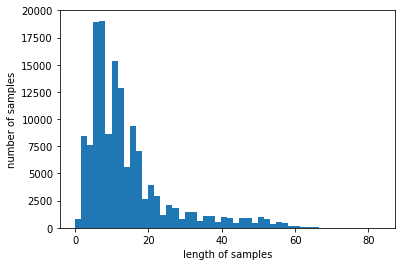

In [15]:
print('리뷰의 최대 길이 :',max(len(l) for l in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

최대 문장 길이 지정

In [16]:
total_data_text = list(X_train) + list(X_test)
# 텍스트데이터 문장길이의 리스트를 생성한 후
num_tokens = [len(tokens) for tokens in total_data_text]
num_tokens = np.array(num_tokens)
# 문장길이의 평균값, 최대값, 표준편차를 계산해 본다. 
print('문장길이 평균 : ', np.mean(num_tokens))
print('문장길이 최대 : ', np.max(num_tokens))
print('문장길이 표준편차 : ', np.std(num_tokens))

# 예를들어, 최대 길이를 (평균 + 2*표준편차)로 한다면,  
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
maxlen = int(max_tokens)
print('pad_sequences maxlen : ', maxlen)
print('전체 문장의 {}가 maxlen 설정값 이내에 포함됩니다. '.format(np.sum(num_tokens < max_tokens) / len(num_tokens)))

문장길이 평균 :  14.528138730242716
문장길이 최대 :  105
문장길이 표준편차 :  11.921158321890513
pad_sequences maxlen :  38
전체 문장의 0.9352204879212769가 maxlen 설정값 이내에 포함됩니다. 


패딩 추가

padding을 'post'와 'pre'로 모두 해본 결과, 그나마 'post'가 더 나았다.

In [17]:
X_train = keras.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_to_index["<PAD>"],
                                                        padding='post', # 혹은 'pre'
                                                        maxlen=maxlen)
X_test = keras.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_to_index["<PAD>"],
                                                       padding='post', # 혹은 'pre'
                                                       maxlen=maxlen)

print(X_train.shape)

(143620, 38)


4) 모델 구성 및 validation set 구성

모델을 3가지 이상 다양하게 구성하여 실험해보기

validation 데이터셋 구성

In [18]:
# validation set 40000건 분리 (약30%)
x_val = X_train[:40000]   
y_val = y_train[:40000]

# validation set을 제외한 나머지 약 11만건
partial_x_train = X_train[40000:]  
partial_y_train = y_train[40000:]

print(partial_x_train.shape)
print(partial_y_train.shape)

(103620, 38)
(103620,)


1) LSTM

In [19]:
word_vector_dim = 200  # 워드 벡터의 차원 수 (변경 가능한 하이퍼파라미터)

from keras.layers.core import Dropout

model = keras.Sequential()
model.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model.add(keras.layers.LSTM(128))   # LSTM레이어. LSTM state 벡터의 차원수는 128로 함. (변경 가능)
# model.add(Dropout(0.2))
# model.add(keras.layers.Dense(8, activation='relu'))
model.add(Dropout(0.2))  # 드롭아웃 추가. 비율은 20%
model.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1차원데이터이다.

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 200)         6000000   
_________________________________________________________________
lstm (LSTM)                  (None, 128)               168448    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 129       
Total params: 6,168,577
Trainable params: 6,168,577
Non-trainable params: 0
_________________________________________________________________


2) 1-D CNN: GlobalMaxPooling1D()레이어만 사용

In [20]:
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model2 = keras.Sequential()
model2.add(keras.layers.Embedding(vocab_size, word_vector_dim, input_shape=(None,)))
model2.add(keras.layers.GlobalMaxPooling1D())
model2.add(keras.layers.Dense(8, activation='relu'))
model2.add(keras.layers.Dense(1, activation='sigmoid'))  # 최종 출력은 긍정/부정을 나타내는 1dim 입니다.

model2.summary()


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, None, 200)         6000000   
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 8)                 1608      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 9         
Total params: 6,001,617
Trainable params: 6,001,617
Non-trainable params: 0
_________________________________________________________________


3) GRU (Gated Reccurent Unit)

In [21]:
from tensorflow.keras.layers import GRU
word_vector_dim = 200   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model3.add(GRU(128))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

5) 모델 훈련

In [22]:
# 오버피팅 방지 및 checkpoint저장
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

모델1 (LSTM)

In [23]:
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])
              
epochs=15  # 몇 epoch를 훈련하면 좋을지 결과를 보면서 바꾸어 봅시다. 


history = model.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
810/810 [==============================] - 10s 9ms/step - loss: 0.4262 - accuracy: 0.7911 - val_loss: 0.3684 - val_accuracy: 0.8376
Epoch 2/15
810/810 [==============================] - 7s 9ms/step - loss: 0.2985 - accuracy: 0.8753 - val_loss: 0.3429 - val_accuracy: 0.8544
Epoch 3/15
810/810 [==============================] - 7s 9ms/step - loss: 0.2366 - accuracy: 0.9049 - val_loss: 0.3730 - val_accuracy: 0.8471
Epoch 4/15
810/810 [==============================] - 7s 9ms/step - loss: 0.1911 - accuracy: 0.9250 - val_loss: 0.4104 - val_accuracy: 0.8481
Epoch 5/15
810/810 [==============================] - 7s 9ms/step - loss: 0.1564 - accuracy: 0.9402 - val_loss: 0.4775 - val_accuracy: 0.8441
Epoch 6/15
810/810 [==============================] - 7s 9ms/step - loss: 0.1306 - accuracy: 0.9496 - val_loss: 0.5172 - val_accuracy: 0.8440
Epoch 7/15
810/810 [==============================] - 7s 8ms/step - loss: 0.1097 - accuracy: 0.9585 - val_loss: 0.4998 - val_accuracy: 0.8390


In [24]:
results = model.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.5180 - accuracy: 0.8280
[0.5180185437202454, 0.8280407786369324]


모델2

In [25]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=15  # 하이퍼파라미터


history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
810/810 [==============================] - 3s 4ms/step - loss: 0.4313 - accuracy: 0.8095 - val_loss: 0.3614 - val_accuracy: 0.8393
Epoch 2/15
810/810 [==============================] - 3s 3ms/step - loss: 0.3406 - accuracy: 0.8539 - val_loss: 0.3507 - val_accuracy: 0.8446
Epoch 3/15
810/810 [==============================] - 3s 4ms/step - loss: 0.3210 - accuracy: 0.8652 - val_loss: 0.3484 - val_accuracy: 0.8471
Epoch 4/15
810/810 [==============================] - 3s 3ms/step - loss: 0.3089 - accuracy: 0.8716 - val_loss: 0.3493 - val_accuracy: 0.8473
Epoch 5/15
810/810 [==============================] - 3s 3ms/step - loss: 0.3001 - accuracy: 0.8762 - val_loss: 0.3491 - val_accuracy: 0.8479
Epoch 6/15
810/810 [==============================] - 3s 3ms/step - loss: 0.2922 - accuracy: 0.8806 - val_loss: 0.3495 - val_accuracy: 0.8490
Epoch 7/15
810/810 [==============================] - 3s 3ms/step - loss: 0.2841 - accuracy: 0.8850 - val_loss: 0.3489 - val_accuracy: 0.8491
Epoch 

In [26]:
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3645 - accuracy: 0.8408
[0.3645184636116028, 0.8407754898071289]


모델 정의하는 코드를 다시 실행후, 다른 하이퍼파라미터로 학습시켜보자.

batch_size 축소

In [27]:
model2.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=15  # 하이퍼파라미터


history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
1620/1620 [==============================] - 6s 3ms/step - loss: 0.2742 - accuracy: 0.8903 - val_loss: 0.3549 - val_accuracy: 0.8493
Epoch 2/15
1620/1620 [==============================] - 5s 3ms/step - loss: 0.2733 - accuracy: 0.8905 - val_loss: 0.3543 - val_accuracy: 0.8461
Epoch 3/15
1620/1620 [==============================] - 5s 3ms/step - loss: 0.2711 - accuracy: 0.8924 - val_loss: 0.3578 - val_accuracy: 0.8486
Epoch 4/15
1620/1620 [==============================] - 5s 3ms/step - loss: 0.2692 - accuracy: 0.8935 - val_loss: 0.3619 - val_accuracy: 0.8443
Epoch 5/15
1620/1620 [==============================] - 5s 3ms/step - loss: 0.2671 - accuracy: 0.8946 - val_loss: 0.3557 - val_accuracy: 0.8475
Epoch 6/15
1620/1620 [==============================] - 5s 3ms/step - loss: 0.2649 - accuracy: 0.8958 - val_loss: 0.3571 - val_accuracy: 0.8472
Epoch 7/15
1620/1620 [==============================] - 5s 3ms/step - loss: 0.2621 - accuracy: 0.8972 - val_loss: 0.3572 - val_accuracy:

In [28]:
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.3709 - accuracy: 0.8375
[0.3708673119544983, 0.8375409245491028]


LSTM모델과 같은 최적화함수 adam를 사용해보자.

optimizer 변경, epochs 증가,early stop의 patience 증가

In [29]:
# 오버피팅 방지 및 checkpoint저장
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=7),
             keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [30]:
model2.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=20  # 하이퍼파라미터


history2 = model2.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/20
810/810 [==============================] - 5s 6ms/step - loss: 0.2571 - accuracy: 0.8991 - val_loss: 0.3545 - val_accuracy: 0.8480
Epoch 2/20
810/810 [==============================] - 4s 6ms/step - loss: 0.2180 - accuracy: 0.9173 - val_loss: 0.3668 - val_accuracy: 0.8470
Epoch 3/20
810/810 [==============================] - 4s 5ms/step - loss: 0.1704 - accuracy: 0.9388 - val_loss: 0.4024 - val_accuracy: 0.8383
Epoch 4/20
810/810 [==============================] - 4s 5ms/step - loss: 0.1222 - accuracy: 0.9584 - val_loss: 0.4558 - val_accuracy: 0.8320
Epoch 5/20
810/810 [==============================] - 4s 5ms/step - loss: 0.0822 - accuracy: 0.9741 - val_loss: 0.5258 - val_accuracy: 0.8246
Epoch 6/20
810/810 [==============================] - 4s 5ms/step - loss: 0.0541 - accuracy: 0.9839 - val_loss: 0.5878 - val_accuracy: 0.8213
Epoch 7/20
810/810 [==============================] - 4s 6ms/step - loss: 0.0359 - accuracy: 0.9898 - val_loss: 0.6623 - val_accuracy: 0.8167
Epoch 

In [31]:
results = model2.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 2s - loss: 0.7218 - accuracy: 0.8083
[0.7218092083930969, 0.8083080649375916]


모델3

In [32]:
# 오버피팅 방지 및 checkpoint저장
callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss',
                                           patience=5),
             keras.callbacks.ModelCheckpoint(filepath='best_model.h5',
                                             monitor='val_loss',
                                             save_best_only=True)]

In [33]:
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=15  # 하이퍼파라미터


history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=128,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
810/810 [==============================] - 7s 7ms/step - loss: 0.4697 - accuracy: 0.7542 - val_loss: 0.3526 - val_accuracy: 0.8436
Epoch 2/15
810/810 [==============================] - 5s 6ms/step - loss: 0.3248 - accuracy: 0.8606 - val_loss: 0.3308 - val_accuracy: 0.8549
Epoch 3/15
810/810 [==============================] - 5s 6ms/step - loss: 0.2925 - accuracy: 0.8769 - val_loss: 0.3249 - val_accuracy: 0.8564
Epoch 4/15
810/810 [==============================] - 5s 6ms/step - loss: 0.2665 - accuracy: 0.8912 - val_loss: 0.3369 - val_accuracy: 0.8556
Epoch 5/15
810/810 [==============================] - 5s 6ms/step - loss: 0.2435 - accuracy: 0.9028 - val_loss: 0.3482 - val_accuracy: 0.8592
Epoch 6/15
810/810 [==============================] - 5s 6ms/step - loss: 0.2213 - accuracy: 0.9128 - val_loss: 0.3370 - val_accuracy: 0.8569
Epoch 7/15
810/810 [==============================] - 5s 6ms/step - loss: 0.2025 - accuracy: 0.9214 - val_loss: 0.3475 - val_accuracy: 0.8529
Epoch 

In [34]:
results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 3s - loss: 0.3759 - accuracy: 0.8456
[0.37587451934814453, 0.8455967903137207]


임베딩 벡터 차원과 batch_size를 축소해보았다.

In [35]:
from tensorflow.keras.layers import GRU
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model3.add(GRU(128))
model3.add(keras.layers.Dense(1, activation='sigmoid'))

In [36]:
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=15  # 하이퍼파라미터


history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
1620/1620 [==============================] - 11s 6ms/step - loss: 0.4596 - accuracy: 0.7615 - val_loss: 0.3568 - val_accuracy: 0.8443
Epoch 2/15
1620/1620 [==============================] - 10s 6ms/step - loss: 0.3302 - accuracy: 0.8568 - val_loss: 0.3438 - val_accuracy: 0.8483
Epoch 3/15
1620/1620 [==============================] - 10s 6ms/step - loss: 0.3002 - accuracy: 0.8739 - val_loss: 0.3330 - val_accuracy: 0.8556
Epoch 4/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.2758 - accuracy: 0.8869 - val_loss: 0.3218 - val_accuracy: 0.8622
Epoch 5/15
1620/1620 [==============================] - 10s 6ms/step - loss: 0.2546 - accuracy: 0.8979 - val_loss: 0.3254 - val_accuracy: 0.8586
Epoch 6/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.2367 - accuracy: 0.9065 - val_loss: 0.3224 - val_accuracy: 0.8609
Epoch 7/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.2204 - accuracy: 0.9131 - val_loss: 0.3339 - val_accur

In [37]:
results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.3983 - accuracy: 0.8448
[0.3982711732387543, 0.8447830677032471]


모델3 개선

모델 다시 정의

In [38]:
from tensorflow.keras.layers import GRU
word_vector_dim = 100   # 단어 하나를 표현하는 임베딩 벡터의 차원 수

model3 = keras.Sequential()
model3.add(keras.layers.Embedding(vocab_size, word_vector_dim))
model3.add(GRU(128))
model.add(Dropout(0.2))  # 드롭아웃 추가. 비율은 20%
model3.add(keras.layers.Dense(1, activation='sigmoid'))

모델 학습 및 평가

In [39]:
model3.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['accuracy'])

              
epochs=15  # 하이퍼파라미터


history3 = model3.fit(partial_x_train,
                    partial_y_train,
                    epochs=epochs,
                    batch_size=64,
                    validation_data=(x_val, y_val),
                    callbacks=callbacks,
                    verbose=1)

Epoch 1/15
1620/1620 [==============================] - 11s 6ms/step - loss: 0.4749 - accuracy: 0.7472 - val_loss: 0.3573 - val_accuracy: 0.8436
Epoch 2/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.3318 - accuracy: 0.8572 - val_loss: 0.3399 - val_accuracy: 0.8511
Epoch 3/15
1620/1620 [==============================] - 10s 6ms/step - loss: 0.3008 - accuracy: 0.8737 - val_loss: 0.3281 - val_accuracy: 0.8571
Epoch 4/15
1620/1620 [==============================] - 10s 6ms/step - loss: 0.2740 - accuracy: 0.8885 - val_loss: 0.3167 - val_accuracy: 0.8598
Epoch 5/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.2528 - accuracy: 0.8990 - val_loss: 0.3215 - val_accuracy: 0.8587
Epoch 6/15
1620/1620 [==============================] - 10s 6ms/step - loss: 0.2347 - accuracy: 0.9074 - val_loss: 0.3307 - val_accuracy: 0.8600
Epoch 7/15
1620/1620 [==============================] - 9s 6ms/step - loss: 0.2181 - accuracy: 0.9145 - val_loss: 0.3651 - val_accur

In [40]:
results = model3.evaluate(X_test,  y_test, verbose=2)

print(results)

1537/1537 - 4s - loss: 0.4369 - accuracy: 0.8127
[0.4368743300437927, 0.8127225041389465]


In [41]:
from tensorflow.keras.models import load_model

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 4s 2ms/step - loss: 0.3272 - accuracy: 0.8548

 테스트 정확도: 0.8548


test데이터에 대한 정확도는 85%이다.

6) Loss, Accuracy 그래프 시각화

모델3 시각화

In [42]:
history_dict = history3.history
print(history_dict.keys()) # epoch에 따른 그래프를 그려볼 수 있는 항목들

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


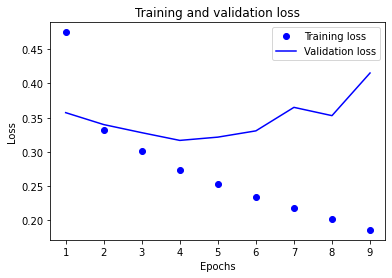

In [43]:
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)

# "bo"는 "파란색 점"입니다
plt.plot(epochs, loss, 'bo', label='Training loss')
# b는 "파란 실선"입니다
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

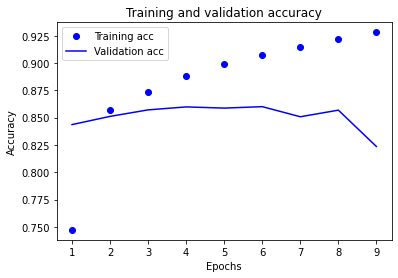

In [44]:
plt.clf()   # 그림을 초기화합니다
## 모델1 시각화
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

7) 학습된 Embedding 레이어 분석

In [45]:
from tensorflow.keras.models import load_model

loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.4f" % (loaded_model.evaluate(X_test, y_test)[1]))

1537/1537 [==============================] - 4s 2ms/step - loss: 0.3272 - accuracy: 0.8548

 테스트 정확도: 0.8548


In [46]:
embedding_layer = loaded_model.layers[0]
weights = embedding_layer.get_weights()[0]
print(weights.shape)    # shape: (vocab_size, embedding_dim)

(30000, 100)


In [47]:
import os

vocab_size = weights.shape[0]
word_vector_dim = weights.shape[1]

# 학습한 Embedding 파라미터를 파일에 써서 저장합니다. 
word2vec_file_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/word2vec.txt'
f = open(word2vec_file_path, 'w')
f.write('{} {}\n'.format(vocab_size-4, word_vector_dim))  # 몇개의 벡터를 얼마 사이즈로 기재할지 타이틀을 씁니다.

# 단어 개수(에서 특수문자 4개는 제외하고)만큼의 워드 벡터를 파일에 기록합니다. 
vectors = loaded_model.get_weights()[0]
for i in range(4,vocab_size):
    f.write('{} {}\n'.format(index_to_word[i], ' '.join(map(str, list(vectors[i, :])))))
f.close()

In [48]:
from gensim.models.keyedvectors import Word2VecKeyedVectors

# 저장한 워드 벡터 다시 로드
word_vectors = Word2VecKeyedVectors.load_word2vec_format(word2vec_file_path, binary=False)
vector = word_vectors['영화']
vector

array([ 0.16543026, -0.08785205, -0.02211877, -0.00583439, -0.01294077,
        0.08597049,  0.00731607, -0.207857  ,  0.26341426, -0.14873621,
       -0.10410136,  0.15215263,  0.00125195, -0.08981722, -0.11994532,
       -0.18737926, -0.01870199, -0.03417141, -0.17119819, -0.10630539,
       -0.05150998,  0.04988074, -0.07524101, -0.03978757, -0.06972987,
        0.10967208, -0.04714815,  0.1781501 ,  0.00857994, -0.02869519,
       -0.00451393, -0.176514  , -0.04429872,  0.03828963, -0.09892742,
        0.0327227 , -0.07551847,  0.10359889,  0.0889267 , -0.1275245 ,
        0.04733416,  0.07215473,  0.02192838,  0.08764781, -0.18299228,
        0.128193  , -0.21197301,  0.09047857, -0.14676282,  0.1712235 ,
       -0.1440083 , -0.20923282, -0.16531955, -0.16650279,  0.01661986,
        0.10873449,  0.05395607, -0.12982695,  0.12091354, -0.07506291,
        0.19151494,  0.25633505, -0.06451955,  0.14639701,  0.05255519,
       -0.02799005, -0.04820269,  0.02325187,  0.08597124,  0.20

gensim의 Word2VecKeyedVectors는 한국어에 대해서는 제대로 된 결과를 도출하지 못한다.

In [49]:
keys = []
for key, distance in word_vectors.similar_by_word('영화'):
    print(key)
    keys.append(word_to_index[key])

는다
세요
고
한다는
여
자꾸
임
니
구
스릴러


8) 한국어 Word2Vec 임베딩 활용하여 성능개선

한국어 Word2Vec 임베딩 활용하기

In [53]:
!pip install --upgrade gensim==3.8.3

     |████████████████████████████████| 23.4 MB 5.9 MB/s            
  Preparing metadata (setup.py) ... done
  Created wheel for gensim: filename=gensim-3.8.3-cp39-cp39-linux_x86_64.whl size=24328218 sha256=81f0a6a55d286f4a0e3acf4facaced3607306282de259f18a2e353291f20cad7
  Stored in directory: /aiffel/.cache/pip/wheels/ca/5d/af/618594ec2f28608c1d6ee7d2b7e95a3e9b06551e3b80a491d6
Successfully built gensim
  Attempting uninstall: gensim
    Found existing installation: gensim 4.1.2
    Uninstalling gensim-4.1.2:
      Successfully uninstalled gensim-4.1.2


In [62]:
!python word2vec-api --model path/to/the/model [--host host --port 1234]

python: can't open file '/aiffel/aiffel/이지수/8. 영화리뷰 텍스트 감성분석하기/word2vec-api': [Errno 2] No such file or directory


In [63]:
!python word2vec-api.py --model /path/to/GoogleNews-vectors-negative300.bin --binary BINARY --path /word2vec --host 0.0.0.0 --port 5000

python: can't open file '/aiffel/aiffel/이지수/8. 영화리뷰 텍스트 감성분석하기/word2vec-api.py': [Errno 2] No such file or directory


In [78]:
ginsim = gensim.models

In [95]:
import gensim
import os

word2vec_path = os.getenv('HOME')+'/aiffel/sentiment_classification/data/ko.bin'
word2vec = gensim.models.Word2Vec.load(word2vec_path)

AttributeError: Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>

In [92]:
A.wv.most_similar('영화')

NameError: name 'A' is not defined

회고

마지막 한국어로도  Word2Vec 임베딩 활용하여 성능 개선을 하면 좋을텐데 자꾸 뜻대로 되지 않고 시간은 흘러간다. 결국 이렇게 제출을 하게 되지만 왜 import하는 과정에서 자꾸 AttributeError가 계속 발생하는지에대해 검색해 보았다.

결론은 호출한 모듈명과 파일명이 같으면 안된다는 것이었다. 모듈명과 변수명을 똑같이 작성한 것이 원인이 되어 나타기도 했고, 모듈에서 가져올 속성의 이름이 오타가 나서 이 모듈에 이런 속성은 없다면서 AttributeError가 나온 경우도 있었고. 다음부터는 변수 이름을 좀 더 신경써서 짓던가 모듈명을 대충 선언하지 말아야겠다. 오류 문구는 Can't get attribute 'Vocab' on <module 'gensim.models.word2vec' from '/opt/conda/lib/python3.9/site-packages/gensim/models/word2vec.py'>였다. 구글링해보니 AttributeError가 많이 나오는 경우를 볼 수 있었는데, 이 오류들의 사례를 조금 더 알아보며 이리 저리 따라해보고 시도해봐야겠다는 생각이 들었다.

 